## Importing Data

### General Imports

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sklearn
import torch

### Data Incoming

In [136]:
ticker_symbol = "TSLA"
ticker = yf.Ticker(ticker_symbol)
historical_data = ticker.history(period="10y")
df = historical_data.copy()

In [137]:
df.sample(5)
df.Dividends.unique()
# Dropping unneeded columns
df = df.drop(columns=['Dividends', 'Stock Splits'])

In [138]:
# target variable: If the closing price will go up (1) or down (0) the next day
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

## Features

### Indicators

In [139]:
# SMA & EMA
def calculate_sma_ema(df, window=5):
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    return df

In [140]:
#Relative Strength Index
def calculate_rsi(df, period):
    delta = df['Close'].diff()  # price change between consecutive days

    gain = delta.where(delta > 0, 0)  # replace negative values by 0
    loss = -delta.where(delta < 0, 0)  # replace positive values by 0 and take absolute

    # Calculate average gain and loss using exponential moving average (EMA)
    avg_gain = gain.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df[f'RSI_{period}'] = rsi
    return df

In [141]:
# MACD
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    # Calculate the short and long EMAs
    ema_short = df['Close'].ewm(span=short_period, adjust=False).mean()
    ema_long = df['Close'].ewm(span=long_period, adjust=False).mean()

    # Calculate MACD line
    df['MACD'] = ema_short - ema_long

    # Calculate Signal line
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    return df

In [142]:
# Create Rolling Window Dataset (5 days → predict next day)
def create_rolling_window_dataset(df, window_size=5):
    feature_cols = [col for col in df.columns if col != 'Target']
    X_list = []
    y_list = []
    
    for i in range(len(df) - window_size):
        # Get 5 days of features
        X_window = df[feature_cols].iloc[i:i+window_size].values  # Shape: (5, num_features)
        # Get target for the next day (day 6)
        y_target = df['Target'].iloc[i+window_size]
        
        X_list.append(X_window.flatten())  # Flatten to 1D: (5*num_features,)
        y_list.append(y_target)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    return X_tensor, y_tensor

### Normalization

In [143]:
# Calculate technical indicators
df = calculate_sma_ema(df, window=5)
df = calculate_rsi(df, period=5)
df = calculate_macd(df)

# Drop NaN rows created by technical indicators
df = df.dropna()

# Create rolling window features (5 days input → predict day 6)
X_tensor, y_tensor = create_rolling_window_dataset(df, window_size=5)

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)

# NORMALIZE FEATURES - Fit scaler on training data only, then transform both
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train.numpy()), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test.numpy()), dtype=torch.float32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target shape: {y_train.shape}")
print(f"Total samples: {len(X_train) + len(X_test)}")


Train shape: torch.Size([2004, 55]), Test shape: torch.Size([502, 55])
Target shape: torch.Size([2004, 1])
Total samples: 2506


In [144]:
df.head()

,Open,High,Low,Close,Volume,Target,SMA_5,EMA_5,RSI_5,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,
2015-11-20 00:00:00-05:00,14.899333,15.000000,14.238667,14.667333,66010500,0,14.549200,14.589687,72.388000,0.081377,0.031206,0.050172
2015-11-23 00:00:00-05:00,14.490000,14.612000,14.312000,14.516667,37893000,1,14.595067,14.565347,51.695423,0.079989,0.040962,0.039027
2015-11-24 00:00:00-05:00,14.358000,14.733333,14.333333,14.550000,37204500,1,14.651733,14.560231,55.234276,0.080648,0.048899,0.031749
2015-11-25 00:00:00-05:00,14.756000,15.388667,14.692000,15.309333,59862000,1,14.766000,14.809932,85.494609,0.140819,0.067283,0.073536
2015-11-27 00:00:00-05:00,15.404000,15.483333,15.134000,15.440667,29241000,0,14.896800,15.020177,87.344193,0.196834,0.093194,0.103640


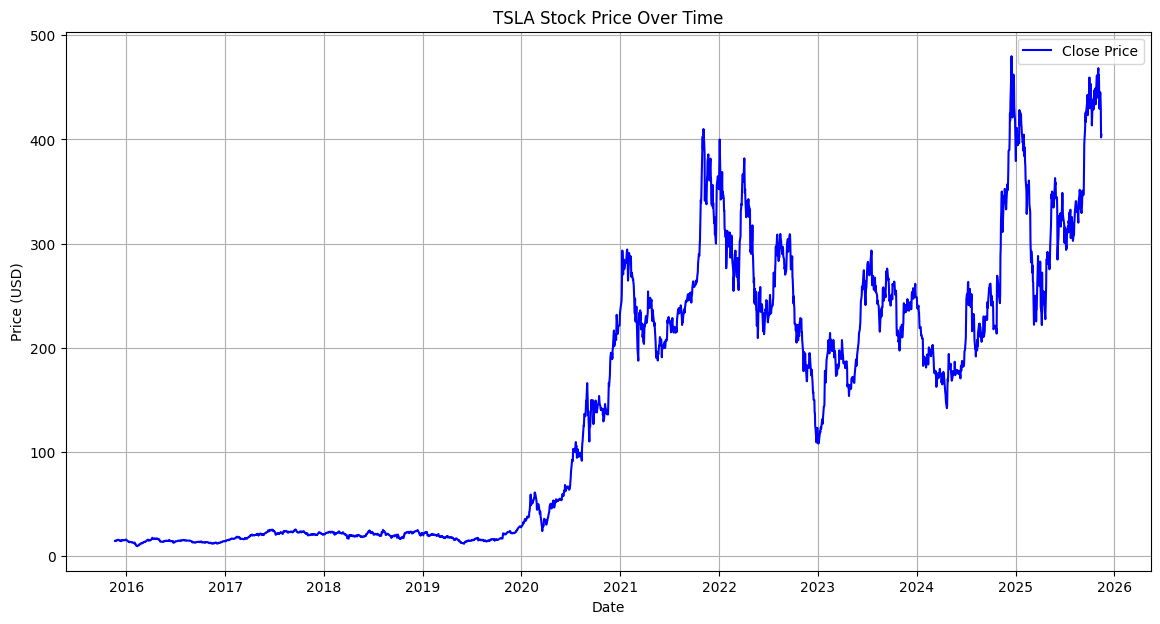

In [145]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker_symbol} Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

## Building The Neural Network

### Model Ingredients

In [146]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [147]:
class StockNNModel(nn.Module):
    def __init__(self,in_features,out_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = in_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features = hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.1), 
            nn.Linear(in_features = hidden_units,out_features=out_features),
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
    
model_v1 = StockNNModel(in_features=55,out_features=1,hidden_units=20).to(device) 
model_v1.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.0377, -0.0063, -0.0193,  ...,  0.1199,  0.1143,  0.0241],
                      [-0.0378, -0.0278, -0.0254,  ...,  0.1192, -0.0894,  0.0865],
                      [ 0.0687, -0.0249, -0.0702,  ...,  0.1226,  0.1034, -0.0192],
                      ...,
                      [-0.0583,  0.0669, -0.0999,  ...,  0.1278, -0.0727, -0.1186],
                      [-0.0672,  0.0365, -0.0725,  ...,  0.0014,  0.0137,  0.1020],
                      [-0.1073,  0.0600,  0.0903,  ..., -0.0053, -0.1227, -0.0860]])),
             ('linear_layer_stack.0.bias',
              tensor([-0.0966,  0.1304, -0.0271,  0.1098,  0.0987, -0.0834, -0.1190, -0.0093,
                      -0.0041, -0.0858, -0.0661, -0.1251,  0.0073,  0.0960, -0.0360,  0.1142,
                       0.1120, -0.1283, -0.0907,  0.0866])),
             ('linear_layer_stack.3.weight',
              tensor([[-0.1353,  0.1840,  0.0431,  0.1475,  0.1394,  0.1655,  0.0792

### Predicting Without training on random weights and biases

224 predicted as Up (1) out of 502


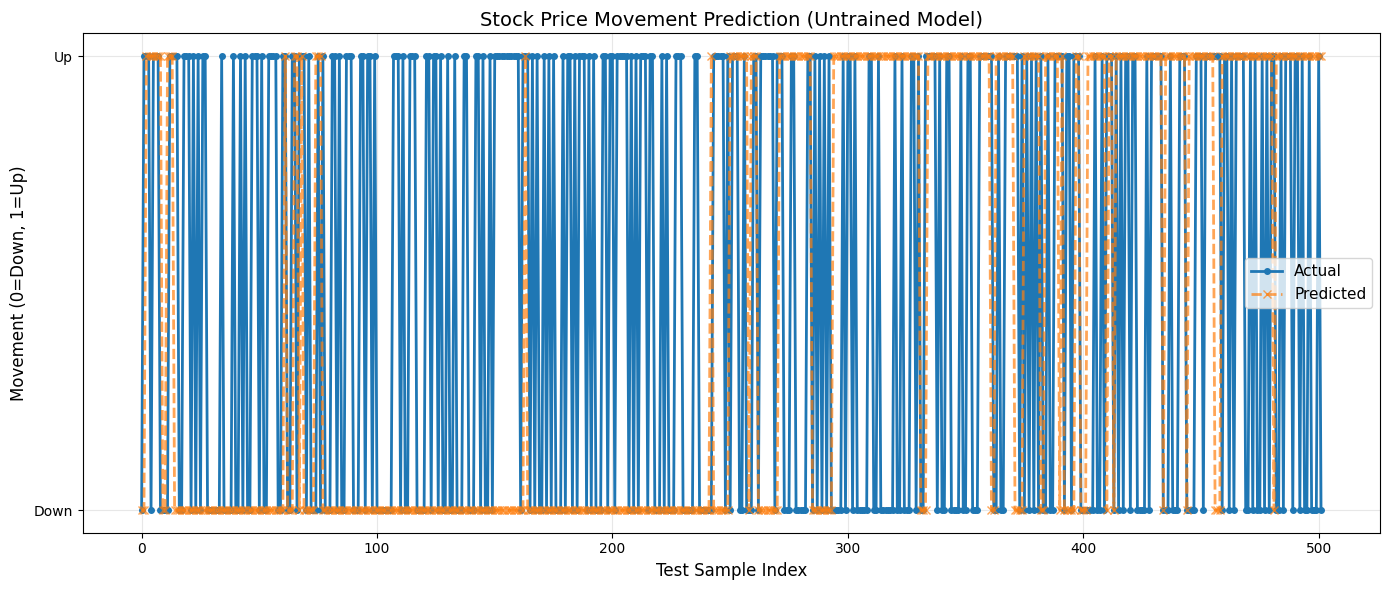


Untrained Model Accuracy: 49.80%


In [148]:
# Prediction Without Training 
model_v1.eval()
with torch.inference_mode():
    y_preds = model_v1(X_test.to(device))

# Convert predictions to binary (0 or 1) using sigmoid threshold
y_preds_binary = (torch.sigmoid(y_preds) > 0.5).float()
print(y_preds_binary.count_nonzero().item(), "predicted as Up (1) out of", y_preds_binary.shape[0])

# Plot the predictions vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_test.cpu().numpy(), label='Actual', marker='o', linestyle='-', linewidth=2, markersize=4)
plt.plot(y_preds_binary.cpu().numpy(), label='Predicted', marker='x', linestyle='--', linewidth=2, markersize=6, alpha=0.7)
plt.title('Stock Price Movement Prediction (Untrained Model)', fontsize=14)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Movement (0=Down, 1=Up)', fontsize=12)
plt.yticks([0, 1], ['Down', 'Up'])
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate accuracy
accuracy = (y_preds_binary == y_test).float().mean()
print(f"\nUntrained Model Accuracy: {accuracy.item():.2%}")

### Training and Testing Loop -- Model Cooking

In [149]:
# Loss and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.001,weight_decay=0.01)

In [150]:
# Training Loop
epochs = 100
torch.manual_seed(42)

# Put data to target device
X_train, y_train = X_train.to(device) , y_train.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

# Early Stopping Parameters
best_test_loss = float('inf')
patience = 30
patience_counter = 0
best_model_state = None

for epoch in range(epochs):
    ### TRAINING PHASE
    model_v1.train()  
    ## 1. Forward pass
    y_logits = model_v1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    ## 2. Calculate loss/accuracy
    loss = loss_fn(y_logits,
                   y_train.squeeze()) # nn.BCEWithLogitsLoss expects raw logits as input
    # 3.  Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss Backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing 
    model_v1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_v1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate test loss
        test_loss = loss_fn(test_logits,y_test.squeeze())
    
        # Early Stopping Check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model_v1.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch}")
            model_v1.load_state_dict(best_model_state)
            break
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f} ")
        
    

Epoch: 0 | Loss: 0.70108 | Test Loss: 0.69614 
Epoch: 10 | Loss: 0.69469 | Test Loss: 0.69453 
Epoch: 20 | Loss: 0.69255 | Test Loss: 0.69336 
Epoch: 30 | Loss: 0.69148 | Test Loss: 0.69277 
Epoch: 40 | Loss: 0.69043 | Test Loss: 0.69258 
Epoch: 50 | Loss: 0.69039 | Test Loss: 0.69212 
Epoch: 60 | Loss: 0.69067 | Test Loss: 0.69188 
Epoch: 70 | Loss: 0.68988 | Test Loss: 0.69176 
Epoch: 70 | Loss: 0.68988 | Test Loss: 0.69176 
Epoch: 80 | Loss: 0.68958 | Test Loss: 0.69128 
Epoch: 90 | Loss: 0.68907 | Test Loss: 0.69151 
Epoch: 80 | Loss: 0.68958 | Test Loss: 0.69128 
Epoch: 90 | Loss: 0.68907 | Test Loss: 0.69151 


In [151]:
## Predicting After Training
model_v1.eval()
with torch.inference_mode():
    y_preds = model_v1(X_test.to(device))
    y_preds_binary = (torch.sigmoid(y_preds) > 0.5).float()


# Calculate accuracy
accuracy = (y_preds_binary == y_test).float().mean()
print(f"\nTrained Model Accuracy: {accuracy.item():.2%}")


Trained Model Accuracy: 53.19%


## Logistic Regression

In [152]:
# Logistic Regression Model using sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert torch tensors back to numpy for sklearn
X_train_np = X_train.cpu().numpy()
X_test_np = X_test.cpu().numpy()
y_train_np = y_train.cpu().numpy().ravel()  # flatten to 1D
y_test_np = y_test.cpu().numpy().ravel()

# Initialize and train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_np, y_train_np)

# Make predictions
y_pred_train = log_reg.predict(X_train_np)
y_pred_test = log_reg.predict(X_test_np)

# Calculate accuracies
train_accuracy = accuracy_score(y_train_np, y_pred_train)
test_accuracy = accuracy_score(y_test_np, y_pred_test)

print("=" * 60)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_test, target_names=['Down (0)', 'Up (1)']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_test))

LOGISTIC REGRESSION RESULTS
Training Accuracy: 55.44%
Test Accuracy: 52.99%

Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.53      0.38      0.44       248
      Up (1)       0.53      0.68      0.59       254

    accuracy                           0.53       502
   macro avg       0.53      0.53      0.52       502
weighted avg       0.53      0.53      0.52       502


Confusion Matrix:
[[ 93 155]
 [ 81 173]]


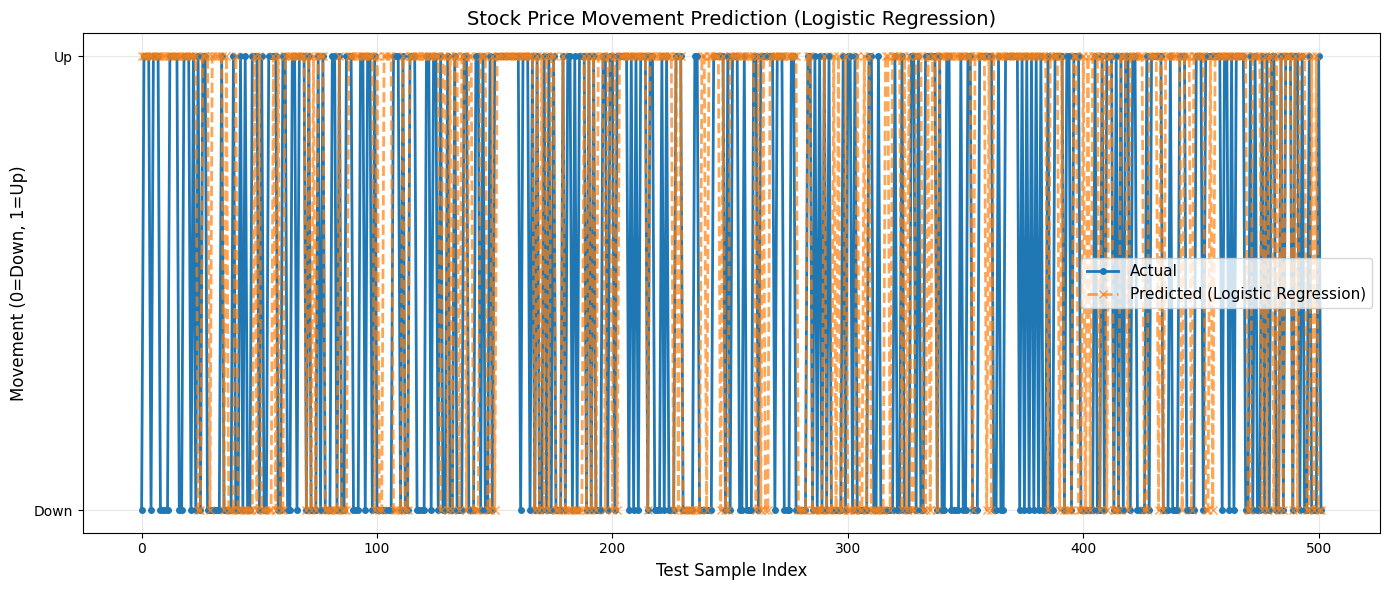


MODEL COMPARISON
Neural Network Test Accuracy: 53.19%
Logistic Regression Test Accuracy: 52.99%


In [153]:
# Visualize Logistic Regression Predictions vs Actual
plt.figure(figsize=(14, 6))
plt.plot(y_test_np, label='Actual', marker='o', linestyle='-', linewidth=2, markersize=4)
plt.plot(y_pred_test, label='Predicted (Logistic Regression)', marker='x', linestyle='--', linewidth=2, markersize=6, alpha=0.7)
plt.title('Stock Price Movement Prediction (Logistic Regression)', fontsize=14)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Movement (0=Down, 1=Up)', fontsize=12)
plt.yticks([0, 1], ['Down', 'Up'])
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Compare with Neural Network
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"Neural Network Test Accuracy: {accuracy.item():.2%}")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.2%}")
print("=" * 60)